In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import numpy as np 
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize

Melihat data

In [2]:
df = pd.read_csv('consumer_complaints.csv', usecols=('product', 'consumer_complaint_narrative'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   product                       555957 non-null  object
 1   consumer_complaint_narrative  66806 non-null   object
dtypes: object(2)
memory usage: 8.5+ MB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(len(df))
df.head()

555957


,product,consumer_complaint_narrative
0,Mortgage,NaN
1,Mortgage,NaN
2,Credit reporting,NaN
3,Student loan,NaN
4,Debt collection,NaN


Menghapus kolom yang tidak memiliki nilai

In [4]:
df = df.dropna()
print(len(df))
df.head()

66806


,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...


In [5]:
print(df['product'].value_counts())

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


Melihat data komplain

In [6]:
texts = df['consumer_complaint_narrative'].values
print(texts[:1])

['XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n']


Membersihkan data

In [8]:
import nltk
nltk.download('stopwords')
df = df.reset_index(drop=True)
replace_space = re.compile('[/(){}\[\]\|@,;]')
remove_char = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def cleanin_text(text):
    text = text.lower() #mengubah ke huruf kecil
    text = replace_space.sub(' ', text) #mengganti simbol dengan space.
    text = remove_char.sub('', text) #menghapus simbol. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) #menghapus stopwords
    return text

df['consumer_complaint_narrative'] = df['consumer_complaint_narrative'].apply(cleaning_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Data yang sudah dibersihkan

In [9]:
texts = df['consumer_complaint_narrative'].apply(clean_text).values
print(texts[:1])

['claimed owe 2700 years despite proof payment sent canceled check ownpaid invoice 2700 continue insist owe collection agencies stop harassment bill already paid four years ago']


In [10]:
narrative = df['consumer_complaint_narrative'].values
label = Y = pd.get_dummies(df["product"]).values

Membagi data menjadi training dan test set

In [11]:
narrative_train, narrative_test, label_train, label_test = train_test_split(narrative, label, test_size=0.2, random_state = 25)
print(len(narrative_train))
print(len(narrative_test))

53444
13362


Tokenizer text

In [12]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(narrative_train)

sequences_train = tokenizer.texts_to_sequences(narrative_train)
sequences_test = tokenizer.texts_to_sequences(narrative_test)
 
padded_train = pad_sequences(sequences_train, maxlen= 250) 
padded_test = pad_sequences(sequences_test, maxlen=250)

In [13]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(11, activation='softmax')
])

model.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          80000     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               46800     
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                715       
Total params: 148,699
Trainable params: 148,699
Non-trainable params: 0
__________________________________________________

In [14]:
from keras.callbacks import EarlyStopping
epochs = 10
batch_size = 64

callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1)]
history = model.fit(padded_train, label_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callbacks])

Epoch 1/10
752/752 [==============================] - 45s 16ms/step - loss: 1.6338 - accuracy: 0.3862 - val_loss: 0.9889 - val_accuracy: 0.6909
Epoch 2/10
752/752 [==============================] - 12s 16ms/step - loss: 0.9511 - accuracy: 0.7135 - val_loss: 0.9226 - val_accuracy: 0.7190
Epoch 3/10
752/752 [==============================] - 12s 16ms/step - loss: 0.7623 - accuracy: 0.7776 - val_loss: 0.7196 - val_accuracy: 0.7865
Epoch 4/10
752/752 [==============================] - 11s 15ms/step - loss: 0.6675 - accuracy: 0.8027 - val_loss: 0.6550 - val_accuracy: 0.8109
Epoch 5/10
752/752 [==============================] - 11s 15ms/step - loss: 0.5968 - accuracy: 0.8270 - val_loss: 0.5759 - val_accuracy: 0.8337
Epoch 6/10
752/752 [==============================] - 12s 15ms/step - loss: 0.5461 - accuracy: 0.8428 - val_loss: 0.6367 - val_accuracy: 0.8193
Epoch 7/10
752/752 [==============================] - 11s 14ms/step - loss: 0.5144 - accuracy: 0.8522 - val_loss: 0.5799 - val_accuracy:

Plot akurasi dan loss

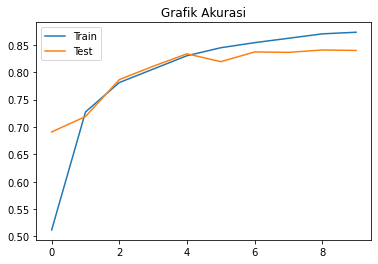

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title('Grafik Akurasi')
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.legend()
plt.show();

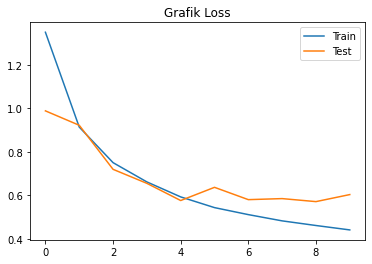

In [16]:
plt.title('Grafik Loss')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.show();